In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import sys, PIL.Image, matplotlib.pyplot as plt, itertools, math, random, collections, torch, inspect
from functools import wraps, partial
from dataclasses import dataclass, field
import inspect
import random
from copy import copy, deepcopy
from typing import Dict, Any, AnyStr, List, Sequence, TypeVar, Tuple, Optional, Union, Iterable, cast, Collection, Callable
from numpy import cos, sin, tan, tanh, log, exp
from pdb import set_trace
import torch.nn.functional as F
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import scipy
import scipy.stats, scipy.special
from tqdm import tqdm, tqdm_notebook, tnrange
import numpy as np
from torchvision.models import resnet34

In [3]:
tqdm = tqdm_notebook

In [4]:
def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def get_arg_names(func):
    return list(inspect.signature(func).parameters)

def get_dynamic_var_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()}

def bind_args(func, v):
    arg_names = get_arg_names(func)
    bound_args = { arg_names[i]: vi for i, vi in enumerate(v)}
    return bound_args
        

def resolve_fun_annotations(func, kwargs):
    params = copy(func.__annotations__)
    resolved = {}
    for k, v in kwargs.items():
        if k in params and not isinstance(v, Dynamic):
            rand_func = params[k]
            if isinstance(v, Dict): resolved[k] = rand_func(**v)
            elif isinstance(v, Iterable):
                arg_names = get_arg_names(rand_func)
                bound_args = bind_args(rand_func, v)
                resolved[k] = rand_func(**bound_args)
            else: 
                # gross hack
                if rand_func == Bool and k == 'p':
                    resolved[k] = rand_func(v)
                else:
                    resolved[k] = v
        else: resolved[k] = v
    return resolved


def dynamic_resolve(a):
    if isinstance(a, Dynamic): return a.resolve()
    else: return a

def dynamic_release(a):
    if isinstance(a, Dynamic): return a.release()
    elif isinstance(a, list):
        for ai in a: dynamic_release(ai)
    elif isinstance(a, dict):
        for vi in a.values(): dynamic_release(vi)
            
class Dynamic(object):
    def __init__(self, func=None, args=None, kwargs=None):
        self.func = func       
        self.args = args
        self.kwargs = resolve_fun_annotations(self.func, kwargs) if kwargs else {}
        self.def_args = get_default_args(self.func) 
        self.init_state()
        
    def init_state(self):
        self.value_ = None
        self.bound = False
        self.bound_args = {}
        self.bound_kwargs = {}

    def clone(self, **kwargs):
        copy_kwargs = {k:copy(v) for k,v in self.kwargs.items()}
        copy_args = copy(self.args)
        kwargs = {**copy_kwargs, **kwargs}
        dtype = type(self)
        new_dynamic = dtype(func=self.func, args=copy_args, kwargs=kwargs)
        new_dynamic.__dict__.update({k:v for k,v in self.__dict__.items()
                                     if k not in new_dynamic.__dict__})
        return new_dynamic
    
    def __copy__(self):
        return self.clone()
    
    def bind(self, **kwargs):
        if not self.bound:
            kwargs = resolve_fun_annotations(self.func, kwargs) 
            self.bound_args = bind_args(self.func, self.args) if self.args else {}
            kwargs = {**self.def_args, **self.kwargs, **self.bound_args, **kwargs}
            kwargs = {k:dynamic_resolve(v) for k,v in kwargs.items()}
            self.bound = True
            self.bound_kwargs = kwargs
            self.value = None
        elif kwargs:
            kwargs = resolve_fun_annotations(self.func, kwargs)
            kwargs = {k:dynamic_resolve(v) for k,v in kwargs.items()}
            self.bound_kwargs = {**self.bound_kwargs, **self.bound_args, **kwargs}
            self.value = None
                   
    def release(self):
        dynamic_release(self.kwargs)
        dynamic_release(self.bound_args)
        dynamic_release(self.def_args)
        dynamic_release(self.func)
        self.init_state()
    
    def __repr__(self):
        return f'{self.func.__name__}:{self.kwargs}:{self.value_}'
    
                
class DynamicVar(Dynamic):      
    def __init__(self, func=None, args=None, kwargs=None):
        super().__init__(func=func, args=args, kwargs=kwargs)
        
    def resolve(self):
        self.bind()
        if self.value_ is None:
            self.value_ = self.func(**self.bound_kwargs)
        return self.value_


class DynamicFunc(Dynamic):      
    def __init__(self, func=None, args=None, kwargs=None):
        assert(args is None)
        super().__init__(func=func, args=args, kwargs=kwargs)
        
    def resolve(self):
        self.bind()
        return self
    
    def __call__(self, *args, **kwargs):
        self.bind(**kwargs)
        return self.func(*args, **self.bound_kwargs)  


def dynamic_var(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return DynamicVar(func=func, args=args, kwargs=kwargs) 
    return wrapper

def dynamic_func(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        f = DynamicFunc(func=func, kwargs=kwargs)
        if args:return f(*args)
        else: return f
    return wrapper

def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

@dynamic_var
def Uniform(low, high, size=None):
    value = uniform(low, high, size=size)
    return value

@dynamic_var
def LogUniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    value = exp(res) if size is None else res.exp_()
    return value

@dynamic_var
def Bool(p, size=None):
    return uniform(0, 1, size=size)<p

@dynamic_var
def Const(c):
    return c

@dynamic_var
def Choice(choices):
    return random.choice(choices)

In [5]:
@dynamic_func
def maybe(*args,f=None, p:Bool=False, **kwargs):
    #print('maybe',p,f)
    if p: return f(*args, **kwargs)
    else: return args[0]
    

@dynamic_func
def img_wrap(img, f=None, wrap=None):
    return getattr(img, wrap)(f)
    
# sticks a p variable on a function
def Transform(mfunc, order=0, wrap=None):
    dmfunc = dynamic_func(mfunc)
    tfm_type = wrap if wrap else 'unknown'
    @wraps(dmfunc)
    def make_trans(*args,p:Bool=True, **kwargs):
        m = dmfunc(**kwargs)
        if wrap: m = img_wrap(f=m, wrap=wrap)
        res = maybe(*args, f=m, p=p)
        res.order = order
        res.tfm_type = tfm_type
        return res
    make_trans.order = order
    make_trans.tfm_type = tfm_type
    return make_trans

TfmLighting = partial(Transform, order=9, wrap='lighting')
TfmResize = partial(Transform, order=3)
TfmAffine = partial(Transform, order=5, wrap='affine')
TfmPixel = partial(Transform, order=10, wrap='pixel')
TfmCoord = partial(Transform, order=4, wrap='coord')
TfmPad = partial(Transform, order=-10, wrap='pixel')
TfmCrop = partial(Transform, order=99)

def is_lighting(tfm): tfm.tfm_type == 'lighting'
def is_affine(tfm): tfm.tfm_type == 'affine'

In [6]:
@Transform
def mm(x,by:Uniform=2,mode:Bool=True):
    print('mode', mode)
    return x * by

m1 = mm(by=(-2,2),p=0.5)
m1.foobar = 'fred'
m2 = partial(m1, mode=False) 

for i in range(10):
    #if (m1(2) != m2(2,mode=False)):
    print(m1(2), m2(2,mode=False))
    m1.release()

mode True
mode False
3.6488556458579753 3.6488556458579753
mode True
mode False
-2.7221954496844356 -2.7221954496844356
2 2
2 2
mode True
mode False
-1.4747840868691835 -1.4747840868691835
mode True
mode False
-0.7176826830311693 -0.7176826830311693
mode True
mode False
0.5499443625604332 0.5499443625604332
mode True
mode False
-1.1487897235700109 -1.1487897235700109
2 2
2 2


In [7]:

#export
def pil2tensor(image, as_mask=False):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    arr = arr.permute(2,0,1).float()
    return arr if as_mask else arr.div_(255)

def open_image(fn, as_mask=False):
    x = PIL.Image.open(fn)
    if not as_mask: x = x.convert('RGB')
    return pil2tensor(x, as_mask=as_mask)

def image2np(image):
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res



def show_image(img, ax=None, figsize=(3,3), hide_axis=True, alpha=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img),alpha=alpha)
    if hide_axis: ax.axis('off')
    return ax

def show_xy_image(xim, yim, ax=None, figsize=(3,3), alpha=0.5, hide_axis=True):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax1 = show_image(xim, ax=ax, hide_axis=hide_axis)
    show_image(yim, ax=ax1, alpha=alpha,hide_axis=hide_axis)
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows,figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_xy_image(x[i], y[i], ax)
        #show_image(x[i], ax)
        #ax.set_title(classes[y[i]])
    plt.tight_layout()
    
    
class Image():
    def __init__(self, px):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self): return self._px.shape
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.px.shape})'

    def refresh(self):
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            #print('sample', self.sample_kwargs)
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self):
        self.refresh()
        return self._px
    @px.setter
    def px(self,v): self._px=v

    @property
    def flow(self):
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    @flow.setter
    def flow(self,v): self._flow=v

    def lighting(self, func, *args, **kwargs):
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func, *args, **kwargs):
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func, *args, **kwargs):
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func, *args, **kwargs):
        m = func(*args, **kwargs)
        self.affine_mat = self.affine_mat @ self._px.new(m)
        return self

    def set_sample(self, **kwargs):
        self.sample_kwargs = kwargs
        return self

    def resize(self, size):
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self):
        if self._affine_mat is None: self._affine_mat = self._px.new(torch.eye(3))
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v): self._affine_mat=v

    @property
    def logit_px(self):
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v): self._logit_px=v
    
    def show(self, ax=None, **kwargs): show_image(self.px, ax=ax, **kwargs)
    def clone(self): return self.__class__(self.px.clone())
    
    
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if padding_mode=='reflect': padding_mode='reflection'
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(size):
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else torch.Tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else torch.Tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)


def normalize(x, mean,std):   return (x-mean[...,None,None]) / std[...,None,None]
def denormalize(x, mean,std): return x*std[...,None,None] + mean[...,None,None]

def normalize_batch(b, mean, std, do_y=False):
    x,y = b
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean, std, do_y=False, device=None):
    if device is None: device=default_device
    return (partial(normalize_batch, mean=mean.to(device),std=std.to(device), do_y=do_y),
            partial(denormalize,     mean=mean,           std=std))



In [8]:
def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

def logit(x):  return -(1/x-1).log()
def logit_(x): return (x.reciprocal_().sub_(1)).log_().neg_()

@TfmLighting
def brightness(x, change:Uniform=1.0): return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:LogUniform=1.0): return x.mul_(scale)

@TfmAffine
def rotate(degrees:Uniform):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

def get_zoom_mat(sw, sh, c, r):
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

@TfmAffine
def zoom(scale:Uniform=1.0, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return get_zoom_mat(1/scale, 1/scale, col_c, row_c)

@TfmAffine
def squish(scale:Uniform=1.0, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    if scale <= 1: 
        col_c = (1-scale) * (2*col_pct - 1)
        return get_zoom_mat(scale, 1, col_c, 0.)
    else:          
        row_c = (1-1/scale) * (2*row_pct - 1)
        return get_zoom_mat(1, 1/scale, 0., row_c)
    
@TfmCoord
def jitter(c, size, magnitude:Uniform):
    return c.add_((torch.rand_like(c)-0.5)*magnitude*2)

@TfmPixel
def flip_lr(x): 
    print('do flip')
    return x.flip(2)

@TfmPad
def pad(x, padding, mode='reflect'):
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@TfmPixel
def crop(x, size, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()


def compute_zs_mat(sz, scale, squish, invert, row_pct, col_pct):
    orig_ratio = math.sqrt(sz[2]/sz[1])
    for s,r,i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r <= 1: #Test if we are completely inside the picture
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)
        
    #Fallback, hack to emulate a center crop without cropping anything yet.
    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

@TfmCoord
def zoom_squish(c, size, scale:Uniform=1.0, squish:Uniform=1.0, invert:Bool=False, 
                row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = compute_zs_mat(size, scale, squish, invert, row_pct, col_pct)
    return affine_mult(c, FloatTensor(m))


def round_multiple(x, mult): return (int(x/mult+0.5)*mult)

def get_crop_target(target_px, target_aspect=None, mult=32):
    target_px = listify(target_px, 2)
    target_r,target_c = target_px
    if target_aspect:
        target_r = math.sqrt(target_r*target_c/target_aspect)
        target_c = target_r*target_aspect
    return round_multiple(target_r,mult),round_multiple(target_c,mult)

def get_resize_target(img, crop_target, do_crop=False):
    if crop_target is None: return None
    ch,r,c = img.shape
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)


@TfmResize
def resize_image(x, *args, **kwargs): return x.resize(*args, **kwargs)

def _resize(self, size=None, do_crop=False, mult=32):
    assert self._flow is None
    if not size and hasattr(self, 'size'): size = self.size
    aspect = self.aspect if hasattr(self, 'aspect') else None
    crop_target = get_crop_target(size, aspect, mult=mult)
    target = get_resize_target(self, crop_target, do_crop)
    self.flow = affine_grid(target)
    return self
Image.resize=_resize


@TfmCrop
def crop_pad(img, size=None, mult=32, padding_mode=None,
             row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    aspect = img.aspect if hasattr(img, 'aspect') else 1.
    if not size and hasattr(img, 'size'): size = img.size
    if not padding_mode:
        if hasattr(img, 'sample_kwargs') and ('padding_mode' in img.sample_kwargs):
            padding_mode = img.sample_kwargs['padding_mode']
        else: padding_mode='reflect'
    if padding_mode=='zeros': padding_mode='constant'

    rows,cols = get_crop_target(size, aspect, mult=mult)
    x = img.px
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
    row = int((x.size(1)-rows+1)*row_pct)
    col = int((x.size(2)-cols+1)*col_pct)

    x = x[:, row:row+rows, col:col+cols]
    img.px = x.contiguous() # without this, get NaN later - don't know why
    return img

def resize_crop(size=None, do_crop=False, mult=32, rand_crop=False):
    crop_kw = {'row_pct':(0,1.),'col_pct':(0,1.)} if rand_crop else {}
    return [resize_image(size=size, do_crop=do_crop, mult=mult),
            crop_pad(size=size, mult=mult, **crop_kw)]

In [9]:
default_device = torch.device('cuda')
def to_device(device, b): return [o.to(device) for o in b]


@dataclass
class DeviceDataLoader():
    dl: DataLoader
    device: torch.device
    progress_func:Callable=None
    tfms: List[Callable]=None
    half: bool = False

    def __len__(self): return len(self.dl)

    def proc_batch(self,b):
        b = to_device(self.device,b)
        if self.half: b = to_half(b)
        return b if self.tfms is None else self.tfms(b)

    def __iter__(self):
        self.gen = map(self.proc_batch, self.dl)
        if self.progress_func is not None:
            self.gen = self.progress_func(self.gen, total=len(self.dl), leave=False)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device=default_device, progress_func=tqdm, tfms=tfms, **kwargs):
        return cls(DataLoader(*args, **kwargs), device=device, progress_func=progress_func, tfms=tfms, half=False)


class DataBunch():
    def __init__(self, train_dl, valid_dl, device=None, **kwargs):
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader(train_dl, device=self.device, **kwargs)
        self.valid_dl = DeviceDataLoader(valid_dl, device=self.device, **kwargs)

    @classmethod
    def create(cls, train_ds, valid_ds, bs=64, device=None, num_workers=4, progress_func=tqdm,
               train_tfm=None, valid_tfm=None, sample_func=None, dl_tfms=None, **kwargs):
        if train_tfm is not None: train_tfm = DatasetTfm(train_ds, train_tfm, **kwargs)
        if valid_tfm is not None: valid_tfm = DatasetTfm(valid_ds, valid_tfm, **kwargs)
        if sample_func is None:
            train_dl = DataLoader(train_ds, bs,   shuffle=True,  num_workers=num_workers)
            valid_dl = DataLoader(valid_ds, bs*2, shuffle=False, num_workers=num_workers)
        else:
            train_samp = sample_func(train_ds, bs, True)
            valid_samp = sample_func(valid_ds, bs*2, False)
            train_dl = DataLoader(train_ds, num_workers=num_workers, batch_sampler=train_samp)
            valid_dl = DataLoader(valid_ds, num_workers=num_workers, batch_sampler=valid_samp)
        return cls(train_dl, valid_dl, device, tfms=dl_tfms, progress_func=progress_func)
        
    @property
    def train_ds(self): return self.train_dl.dl.dataset
    @property
    def valid_ds(self): return self.valid_dl.dl.dataset
    

In [10]:
PATH = Path('data/carvana')
PATH_PNG = PATH/'train_masks_png'
PATH_X = PATH/'train-128'
PATH_Y = PATH/'train_masks-128'

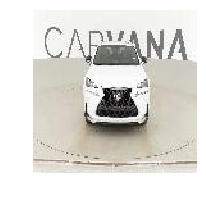

In [11]:
img_f = next(PATH_X.iterdir())
x = open_image(img_f)
show_image(x)

torch.Size([128, 128])

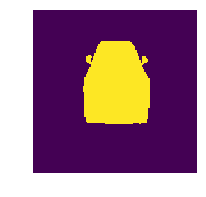

In [12]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}_mask.png'


img_y_f = get_y_fn(img_f)
y = open_image(img_y_f, as_mask=True)
show_image(y)
y[0].shape

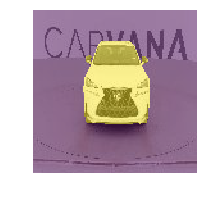

In [13]:
show_xy_image(x,y)

In [14]:
@dataclass
class MatchedFilesDataset(Dataset):
    x_fns:List[Path]; y_fns:List[Path]
    def __post_init__(self): assert len(self.x_fns)==len(self.y_fns)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), open_image(self.y_fns[i],as_mask=True)

In [15]:
def make_segmentation_tfms(tfms):
    seg_tfms = []
    for tfm in tfms:
        if tfm.tfm_type != 'lighting':
            #overrides = {'mode': 'nearest'} if tfm.tfm_type == 'affine' else {}
            #overrides = {}
            seg_tfms.append(tfm)
    return seg_tfms

In [16]:
size = 128
train_tfms = [
    rotate(degrees=(-20,20.)),
    zoom(scale=(1.,1.5)),
    contrast(scale=(0.6,1.4)),
    brightness(change=(0.3,0.7)),
    *resize_crop(size=size, rand_crop=True, do_crop=True)
]
valid_tfms = [
    *resize_crop(size=size, rand_crop=False, do_crop=True)
]

x_train_tfms = train_tfms
y_train_tfms = make_segmentation_tfms(x_train_tfms)
x_valid_tfms = train_tfms
y_valid_tfms = make_segmentation_tfms(x_valid_tfms)


In [17]:
def resolve_tfms(tfms): 
    for f in listify(tfms):
        f.release()
        
def is_listy(x)->bool: return isinstance(x, (tuple,list))

def apply_tfms(tfms, x, do_resolve=True, aspect=None, size=None,
               padding_mode='reflect', **kwargs):
    if not tfms: return x
    tfms = sorted(listify(tfms), key=lambda o: o.order)
    if do_resolve: resolve_tfms(tfms)
    x = Image(x.clone())
    x.set_sample(padding_mode=padding_mode, **kwargs)
    x.aspect = aspect
    x.size = size
    
    for tfm in tfms:
        x = tfm(x)
            
    return x.px

In [18]:
def split_by_idxs(seq, idxs):
    '''A generator that returns sequence pieces, seperated by indexes specified in idxs. '''
    last = 0
    for idx in idxs:
        if not (-len(seq) <= idx < len(seq)):
            raise KeyError(f'Idx {idx} is out-of-bounds')
        yield seq[last:idx]
        last = idx
    yield seq[last:]

def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.
    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]


x_fns = [o for o in PATH_X.iterdir() if o.is_file()]
y_fns = [get_y_fn(o) for o in x_fns]
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(x_fns), np.array(y_fns))
train_ds = MatchedFilesDataset(trn_x, trn_y)
val_ds = MatchedFilesDataset(val_x, val_y)
train_ds, val_ds

(MatchedFilesDataset of len 4080, MatchedFilesDataset of len 1008)

In [19]:
x,y = next(iter(train_ds))
x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

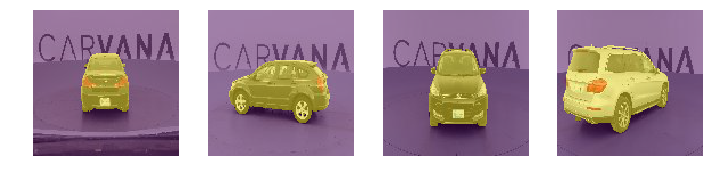

In [20]:
_,axes = plt.subplots(1,4,figsize=(12,3))
for i in range(4):
    imgx,imgy = train_ds[i]
    show_xy_image(imgx, imgy, ax=axes[i])
    #show_image(imgy, axes[1][i], ax=axes)

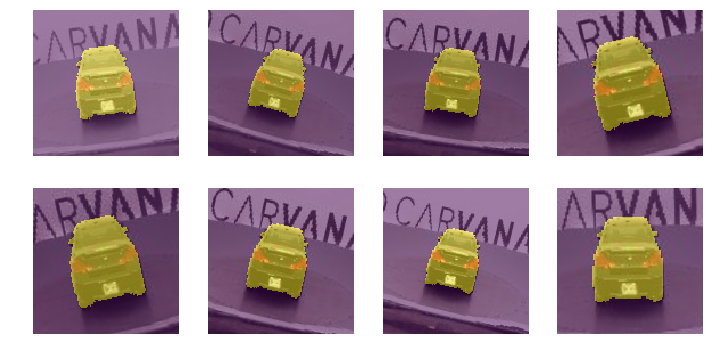

In [21]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(8):
    imgx,imgy = apply_tfms(x_train_tfms, x, do_resolve=True), apply_tfms(y_train_tfms, y, do_resolve=False, mode='nearest')
    #imgx,imgy = x, y
    show_xy_image(imgx, imgy, axes[i//4][i%4])

In [22]:
class DatasetTfm(Dataset):
    def __init__(self, ds:Dataset, x_tfms:Collection[Callable]=None, y_tfms:Collection[Callable]=None):
        self.ds,self.x_tfms,self.y_tfms = ds,x_tfms,y_tfms
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.x_tfms is not None: x = apply_tfms(self.x_tfms, x, do_resolve=True)
        if self.y_tfms is not None: y = apply_tfms(self.y_tfms, y, do_resolve=False, mode='nearest')
        return x,y

In [23]:
train_tds = DatasetTfm(train_ds, x_tfms=x_train_tfms, y_tfms=y_train_tfms)
valid_tds = DatasetTfm(val_ds, x_tfms=x_valid_tfms, y_tfms=y_valid_tfms)

In [24]:
x,y = next(iter(train_tds))
x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

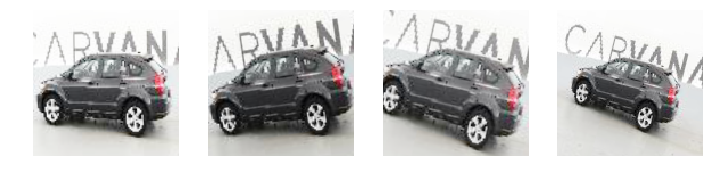

In [25]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(train_tds[1][0], ax)

In [26]:
#imagenet
default_mean, default_std = Tensor([0.485, 0.456, 0.406]), Tensor([0.229, 0.224, 0.225])
default_norm,default_denorm = normalize_funcs(default_mean,default_std)

bs = 64
data = DataBunch.create(train_tds, valid_tds, bs=bs, dl_tfms=default_norm)


tensor(-2.1179) tensor(2.6400) tensor(0.7385) tensor(1.1590)


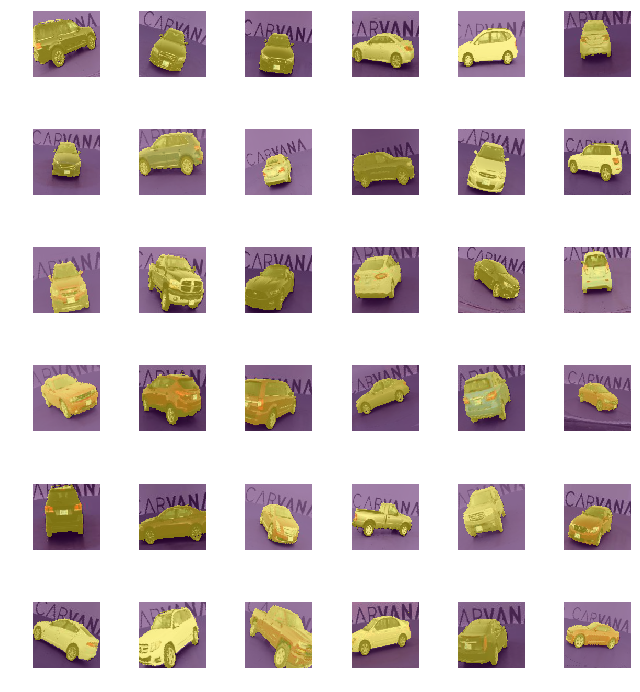

In [27]:
x,y = next(iter(data.train_dl))
x = x.cpu()
y = y.cpu()
print(x.min(),x.max(),x.mean(),x.std())
x = default_denorm(x)
#y = default_denorm(y)
show_images(x,y,6, figsize=(9,10))

In [28]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

In [29]:
def loss_batch(model, xb, yb, loss_fn, opt=None, cb_handler=None, metrics=None):
    if cb_handler is None: cb_handler = CallbackHandler([])
    out = model(xb)
    out = cb_handler.on_loss_begin(out)
    loss = loss_fn(out, yb)
    mets = [f(out,yb).item() for f in metrics] if metrics is not None else []
    
    if opt is not None:
        loss = cb_handler.on_backward_begin(loss)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()
        
    return (loss.item(),) + tuple(mets) + (len(xb),)


def fit(epochs, model, loss_fn, opt, data, callbacks=None, metrics=None):
    cb_handler = CallbackHandler(callbacks)
    cb_handler.on_train_begin()
    
    for epoch in tnrange(epochs):
        model.train()
        cb_handler.on_epoch_begin()
        
        for xb,yb in data.train_dl:
            xb, yb = cb_handler.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
            if cb_handler.on_batch_end(loss): break
        
        if hasattr(data,'valid_dl') and data.valid_dl is not None:
            model.eval()
            with torch.no_grad():
                *val_metrics,nums = zip(*[loss_batch(model, xb, yb, loss_fn, cb_handler=cb_handler, metrics=metrics)
                                for xb,yb in data.valid_dl])
            val_metrics = [np.sum(np.multiply(val,nums)) / np.sum(nums) for val in val_metrics]
            
        else: val_metrics=None
        if cb_handler.on_epoch_end(val_metrics): break
        
    cb_handler.on_train_end()

class Callback():
    def on_train_begin(self, **kwargs): pass         
        #To initiliaze constants in the callback.
    def on_epoch_begin(self, **kwargs): pass
        #At the beginning of each epoch
    def on_batch_begin(self, **kwargs): pass 
        #To set HP before the step is done. 
        #Returns xb, yb (which can allow us to modify the input at that step if needed)
    def on_loss_begin(self, **kwargs): pass
        #Called after the forward pass but before the loss has been computed.
        #Returns the output (which can allow us to modify it)
    def on_backward_begin(self, **kwargs): pass
        #Called after the forward pass and the loss has been computed, but before the back propagation.
        #Returns the loss (which can allow us to modify it, for instance for reg functions)
    def on_backward_end(self, **kwargs): pass
        #Called after the back propagation had been done (and the gradients computed) but before the step of the optimizer.
        #Useful for true weight decay in AdamW
    def on_step_end(self, **kwargs): pass
        #Called after the step of the optimizer but before the gradients are zeroed (not sure this one is useful)
    def on_batch_end(self, **kwargs): pass
        #Called at the end of the batch
    def on_epoch_end(self, **kwargs): pass
        #Called at the end of an epoch
    def on_train_end(self, **kwargs): pass
        #Useful for cleaning up things and saving files/models
        
Floats = Union[float, Collection[float]]

@dataclass
class Learner():
    "Object that wraps together some data, a model, a loss function and an optimizer"
    
    data:DataBunch
    model:nn.Module
    opt_fn:Callable=optim.SGD
    loss_fn:Callable=F.cross_entropy
    metrics:Collection[Callable]=None
    true_wd:bool=False
    layer_groups:Collection[nn.Module]=None
    def __post_init__(self): 
        self.model = self.model.to(self.data.device)
        self.callbacks = []

    def fit(self, epochs:int, lr:Floats, wd:Floats=0., callbacks:Collection[Callback]=None):
        if not hasattr(self, 'opt'): self.create_opt(lr, wd)
        else: self.opt.wd = wd
        if callbacks is None: callbacks = []
        callbacks = self.callbacks + callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, callbacks=callbacks, metrics=self.metrics)
    
    def create_opt(self, lr:Floats, wd:Floats=0.):
        if self.layer_groups is None: self.layer_groups = [self.model]
        lrs = listify(lr, self.layer_groups)
        opt = self.opt_fn([{'params':l.parameters(), 'lr':lr} for l,lr in zip(self.layer_groups, lrs)])
        self.opt = OptimWrapper(opt, wd=wd, true_wd=self.true_wd)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        self.callbacks = [self.recorder] + self.callbacks

def is_tuple(x): return isinstance(x, tuple)

class Stepper():
    def __init__(self, vals, num_it, ft=None):
        self.start,self.end = (vals[0],vals[1]) if is_tuple(vals) else (vals,0)
        self.num_it = num_it
        if ft is None: self.ft = annealing_linear if is_tuple(vals) else annealing_no
        else:          self.ft = ft
        self.n = 0
    
    def step(self):
        self.n += 1
        return self.ft(self.start, self.end, self.n/self.num_it)
    
    @property
    def is_done(self):  return self.n >= self.num_it
    
class OneCycleScheduler(Callback):
    def __init__(self, learn, lr_max, epochs, moms=(0.95,0.85), div_factor=10, pct_end=0.1):
        self.learn = learn
        a = int(len(learn.data.train_dl) * epochs * (1 - pct_end) / 2)
        b = len(learn.data.train_dl) * epochs - 2*a
        self.lr_scheds = [Stepper((lr_max/div_factor, lr_max), a),
                          Stepper((lr_max, lr_max/div_factor), a),
                          Stepper((lr_max/div_factor, lr_max/(div_factor*100)), b)]
        self.mom_scheds = [Stepper(moms, a), Stepper((moms[1], moms[0]), a), Stepper(moms[0], b)]
    
    def on_train_begin(self, **kwargs):
        self.opt = self.learn.opt
        self.opt.lr, self.opt.mom = self.lr_scheds[0].start, self.mom_scheds[0].start
        self.idx_s = 0
    
    def on_batch_end(self, **kwargs):
        if self.idx_s >= len(self.lr_scheds): return True
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        if self.lr_scheds[self.idx_s].is_done:
            self.idx_s += 1

def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exp(start, end, pct): return start * (end/start) ** pct
def annealing_cos(start, end, pct):
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
    
def do_annealing_poly(start, end, pct, degree): return end + (start-end) * (1-pct)**degree
def annealing_poly(degree): return functools.partial(do_annealing_poly, degree=degree)

def _get_init_state(): return {'epoch':0, 'iteration':0, 'num_batch':0}

@dataclass
class CallbackHandler():
    callbacks:Collection[Callable]
    beta:float=0.98
        
    def __post_init__(self):
        self.smoothener = SmoothenValue(self.beta)
        self.state_dict:Dict[str,Union[int,float,Tensor]]=_get_init_state()
    
    def __call__(self, cb_name):
        return [getattr(cb, f'on_{cb_name}')(**self.state_dict) for cb in self.callbacks]
    
    def on_train_begin(self): 
        self.state_dict = _get_init_state()
        self('train_begin')
        
    def on_epoch_begin(self): 
        self.state_dict['num_batch'] = 0
        self('epoch_begin')
        
    def on_batch_begin(self, xb, yb):
        self.state_dict['last_input'], self.state_dict['last_target'] = xb, yb
        for cb in self.callbacks:
            a = cb.on_batch_begin(**self.state_dict)
            if a is not None: self.state_dict['last_input'], self.state_dict['last_target'] = a
        return self.state_dict['last_input'], self.state_dict['last_target']
    
    def on_loss_begin(self, out):
        self.state_dict['last_output'] = out
        for cb in self.callbacks:
            a = cb.on_loss_begin(**self.state_dict)
            if a is not None: self.state_dict['last_output'] = a
        return self.state_dict['last_output']
    
    def on_backward_begin(self, loss):
        self.smoothener.add_value(loss.item())
        self.state_dict['last_loss'], self.state_dict['smooth_loss'] = loss, self.smoothener.smooth
        for cb in self.callbacks:
            a = cb.on_backward_begin(**self.state_dict)
            if a is not None: self.state_dict['last_loss'] = a
        return self.state_dict['last_loss']
    
    def on_backward_end(self):        self('backward_end')
    def on_step_end(self):            self('step_end')
        
    def on_batch_end(self, loss):     
        self.state_dict['last_loss'] = loss
        stop = np.any(self('batch_end'))
        self.state_dict['iteration'] += 1
        self.state_dict['num_batch'] += 1
        return stop
    
    def on_epoch_end(self, val_metrics):
        self.state_dict['last_metrics'] = val_metrics
        stop = np.any(self('epoch_end'))
        self.state_dict['epoch'] += 1
        return stop
    
    def on_train_end(self): self('train_end')
        
class OptimWrapper():
    def __init__(self, opt, wd=0., true_wd=False):
        self.opt,self.true_wd = opt,true_wd
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
        self._wd = wd
    
    #Pytorch optimizer methods
    def step(self):
        # weight decay outside of optimizer step (AdamW)
        if self.true_wd:
            for pg in self.opt.param_groups:
                for p in pg['params']: p.data.mul_(1 - self._wd*pg['lr'])
            self.set_val('weight_decay', 0)
        self.opt.step()
    
    def zero_grad(self): self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self): return self._lr

    @lr.setter
    def lr(self, val): self._lr = self.set_val('lr', val)
    
    @property
    def mom(self): return self._mom

    @mom.setter
    def mom(self, val):
        if 'momentum' in self.opt_keys: self.set_val('momentum', val)
        elif 'betas' in self.opt_keys:  self.set_val('betas', (val, self._beta))
        self._mom = val
    
    @property
    def beta(self): return self._beta

    @beta.setter
    def beta(self, val):
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom,val))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', val)
        self._beta = val
    
    @property
    def wd(self): return self._wd

    @wd.setter
    def wd(self, val):
        if not self.true_wd: self.set_val('weight_decay', val)
        self._wd = val
    
    #Helper functions
    def read_defaults(self):
        self._beta = None
        if 'lr' in self.opt_keys: self._lr = self.opt.param_groups[0]['lr']
        if 'momentum' in self.opt_keys: self._mom = self.opt.param_groups[0]['momentum']
        if 'alpha' in self.opt_keys: self._beta = self.opt.param_groups[0]['alpha']
        if 'betas' in self.opt_keys: self._mom,self._beta = self.opt.param_groups[0]['betas']
        if 'weight_decay' in self.opt_keys: self._wd = self.opt.param_groups[0]['weight_decay']
    
    def set_val(self, key, val):
        for pg in self.opt.param_groups: pg[key] = val
        return val

@dataclass
class Recorder(Callback):
    opt: torch.optim
    train_dl: DeviceDataLoader = None

    def on_train_begin(self, **kwargs):
        self.losses,self.val_losses,self.lrs,self.moms,self.metrics,self.nb_batches = [],[],[],[],[],[]
    
    def on_batch_begin(self, **kwargs):
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)
    
    def on_backward_begin(self, smooth_loss, **kwargs):
        #We record the loss here before any other callback has a chance to modify it.
        self.losses.append(smooth_loss)
        if self.train_dl is not None and self.train_dl.progress_func is not None: 
            self.train_dl.gen.set_postfix_str(smooth_loss)
    
    def on_epoch_end(self, epoch, num_batch, smooth_loss, last_metrics, **kwargs):
        self.nb_batches.append(num_batch)
        if last_metrics is not None:
            self.val_losses.append(last_metrics[0])
            if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
            print(epoch, smooth_loss, *last_metrics)
        else:  print(epoch, smooth_loss)
    
    def plot_lr(self, show_moms=False):
        iterations = list(range(len(self.lrs)))
        if show_moms:
            _, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, self.lrs)
            axs[1].plot(iterations, self.moms)
        else: plt.plot(iterations, self.lrs)
    
    def plot(self, skip_start=10, skip_end=5):
        lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
        _, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_xscale('log')
    
    def plot_losses(self):
        _, ax = plt.subplots(1,1)
        iterations = list(range(len(self.losses)))
        ax.plot(iterations, self.losses)
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        ax.plot(val_iter, self.val_losses)
    
    def plot_metrics(self):
        assert len(self.metrics) != 0, "There is no metrics to plot."
        _, axes = plt.subplots(len(self.metrics[0]),1,figsize=(6, 4*len(self.metrics[0])))
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        axes = axes.flatten() if len(self.metrics[0]) != 1 else [axes]
        for i, ax in enumerate(axes):
            values = [met[i] for met in self.metrics]
            ax.plot(val_iter, values)
            
class SmoothenValue():
    def __init__(self, beta):
        self.beta,self.n,self.mov_avg = beta,0,0
    
    def add_value(self, val):
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)
        
class LRFinder(Callback):
    def __init__(self, opt, data, start_lr=1e-5, end_lr=10, num_it=200):
        self.opt,self.data = opt,data
        self.sched = Stepper((start_lr, end_lr), num_it, annealing_exp)
        #To avoid validating if the train_dl has less than num_it batches, we put aside the valid_dl and remove it
        #during the call to fit.
        self.valid_dl = data.valid_dl
        self.data.valid_dl = None
    
    def on_train_begin(self, **kwargs):
        self.opt.lr = self.sched.start
        self.stop,self.best_loss = False,0.
    
    def on_batch_end(self, iteration, smooth_loss, **kwargs):
        if iteration==0 or smooth_loss < self.best_loss: self.best_loss = smooth_loss
        self.opt.lr = self.sched.step()
        if self.sched.is_done or smooth_loss > 4*self.best_loss:
            #We use the smoothed loss to decide on the stopping since it's less shaky.
            self.stop=True
            return True
    
    def on_epoch_end(self, **kwargs): return self.stop
    
    def on_train_end(self, **kwargs):
        #Clean up and put back the valid_dl in its place.
        self.data.valid_dl = self.valid_dl
        
        
def lr_find(learn, start_lr=1e-5, end_lr=10, num_it=100):
    #TODO: add model.save and model.load.
    learn.create_opt(start_lr)
    cb = LRFinder(learn.opt, learn.data, start_lr, end_lr, num_it)
    a = int(np.ceil(num_it/len(learn.data.train_dl)))
    learn.fit(a, start_lr, callbacks=[cb])

In [30]:
from torchvision.models import resnet34

model_meta = {
    resnet34:[8,6]
}

f = resnet34
cut,lr_cut = model_meta[f]

def cut_model(m, cut):
    return list(m.children())[:cut] if cut else m

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def accuracy(out, yb):
    preds = torch.max(out, dim=1)[1]
    return (preds==yb).float().mean()

USE_GPU = torch.cuda.is_available()
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x #[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

            
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]
    
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [31]:
m_base = get_base()
model = to_gpu(Unet34(m_base))
learn = Learner(data, model)
learn.metrics = [dice]
learn.loss_fn = nn.BCEWithLogitsLoss()
sched = OneCycleScheduler(learn, 0.1, 20)

In [32]:
lr_find(learn)

0 nan


1 nan


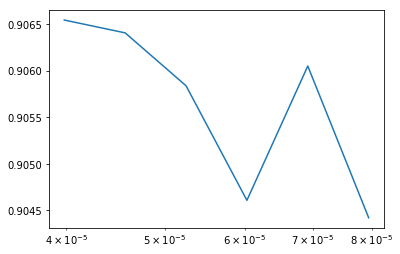

In [33]:
learn.recorder.plot()

In [34]:
learn.fit(20, 0.5, callbacks=[sched])

0 nan nan 0.0


1 nan nan 0.0


2 nan nan 0.0


3 nan nan 0.0


4 nan nan 0.0


5 nan nan 0.0


6 nan nan 0.0


7 nan nan 0.0


8 nan nan 0.0


9 nan nan 0.0


10 nan nan 0.0


11 nan nan 0.0


12 nan nan 0.0


13 nan nan 0.0


14 nan nan 0.0


15 nan nan 0.0


16 nan nan 0.0


17 nan nan 0.0


18 nan nan 0.0


19 nan nan 0.0


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
x,y = next(iter(data.valid_dl))
py = learn.model(x)
py = py.detach()

In [ ]:
show_image(y[0]), show_image(py[0]>0)

In [ ]:
show_image(y[3]), show_image(py[3]>0)

In [ ]:
show_image(y[5]), show_image(py[5]>0)